# 1D Burgers Example

In [45]:
import numpy as np
import numpy.linalg as LA

import matplotlib
import matplotlib.pyplot as plt
from itertools import product

import sys,time
import os
import pickle
import torch

sys.path.append("..") # Adds higher directory to python modules path.
import modLaSDIUtils as lasdiutils
import modAutoEncoder as autoencoder
from WLaSDI import WLaSDI
from WLaSDI_wendy import WLaSDI_wendy
from scipy.interpolate import interp2d, Rbf

### Load data 

In [33]:
# ### Load Data if Model Already Exists ###
snapshot_full = pickle.load(open("./model/1Dburgers_10%0.p", 'rb')) #10% added noise
snapshot_full = snapshot_full['FOM'].astype('float32')
amp_test = np.array([0.8])
width_test = np.array([1.0])
snapshot_full_FOM = pickle.load(open(f"./data/FOM_a{amp_test[0]}_w{width_test[0]}.p",'rb'))
FOM_time = snapshot_full_FOM['time']
snapshot_full_FOM = snapshot_full_FOM['FOM'][:,:-1].astype('float32')


In [34]:
# Set print option
np.set_printoptions(threshold=sys.maxsize)

# Choose device that is not being used
gpu_ids = "0"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

# Set device
device = autoencoder.getDevice()
print("Using device:", device, '\n')

Using device: mps 



In [35]:
# set encoder and decoder types, activation function, etc.
encoder_class = autoencoder.Encoder
decoder_class = autoencoder.Decoder
f_activation = autoencoder.SiLU

maxk = 10
convergence_threshold = 1.0e-8

nx = 1001
dx = 6 / (nx - 1)
nt = 1000
tstop = 1
x=np.linspace(-3, 3, nx)

dt = tstop / nt 
c = dt/dx
t = np.linspace(0, tstop, nt+1)

m = 1000
f = 4
b = 36
db = 12
M2 = b + (m-1)*db
M1 = 2*m
mask = lasdiutils.create_mask_1d(m,b,db)

AE_fname = 'model/AE_git_10pc_0.tar'
encoder, decoder = autoencoder.readAEFromFile(encoder_class,decoder_class,f_activation, mask, m, f, M1, M2, device, AE_fname )

Sparsity in 1000 by 12024 mask: 99.70%


### Generate latent-space trajectories from training data

In [36]:
amp_arr = np.array([.75,.85])
width_arr = np.array([.95,1.05])
P = list(product(amp_arr, width_arr))
P = np.array(P)
latent_space_SS = autoencoder.encodedSnapshots(encoder,snapshot_full,nt+1,device )

## Applying WLaSDI

In [41]:
#Using WSINDy
degree = 1
normal = 1
WLaSDI_model = WLaSDI(encoder, decoder, NN = True, device = device, Local=True, Coef_interp=False, Coef_interp_method=Rbf, nearest_neigh=4)
WLaSDI_model_coef = WLaSDI_model.train_dynamics(latent_space_SS, P, t, degree = degree, gamma = 0.1, threshold=0, overlap=0.7, L = 30, LS_vis=True)

Local approach WITHOUT SINDy coefficient interpolation


In [43]:
features = [
        [lambda x0, x1, x2, x3: x0*0 + 1, lambda x0, x1, x2, x3: x0, lambda x0, x1, x2, x3: x1, lambda x0, x1, x2, x3: x2, lambda x0, x1, x2, x3: x3],
        [lambda x0, x1, x2, x3: x0*0 + 1, lambda x0, x1, x2, x3: x0, lambda x0, x1, x2, x3: x1, lambda x0, x1, x2, x3: x2, lambda x0, x1, x2, x3: x3],
        [lambda x0, x1, x2, x3: x0*0 + 1, lambda x0, x1, x2, x3: x0, lambda x0, x1, x2, x3: x1, lambda x0, x1, x2, x3: x2, lambda x0, x1, x2, x3: x3],
        [lambda x0, x1, x2, x3: x0*0 + 1, lambda x0, x1, x2, x3: x0, lambda x0, x1, x2, x3: x1, lambda x0, x1, x2, x3: x2, lambda x0, x1, x2, x3: x3],
]

degree = 1
normal = 1#np.amax(np.abs(latent_space_LS_list))
WLaSDI_model = WLaSDI_wendy(encoder, decoder, NN = True, device = device, Local = True, Coef_interp=False, Coef_interp_method=Rbf, nearest_neigh = 4)
WLaSDI_model_coef = WLaSDI_model.train_dynamics(latent_space_SS, P, t, features = features, normal = normal, gamma = 0.1, LS_vis = True, ls_meth = "LS", subsample=4, mt_params=[2**i for i in range(4)], toggle_VVp_svd = np.nan)

Local approach WITHOUT SINDy coefficient interpolation


## Generate ROM and visualize results

error: WENDy iterates diverged
Final Position Error: 1.54%


Text(0, 0.5, 'Relative Error (%)')

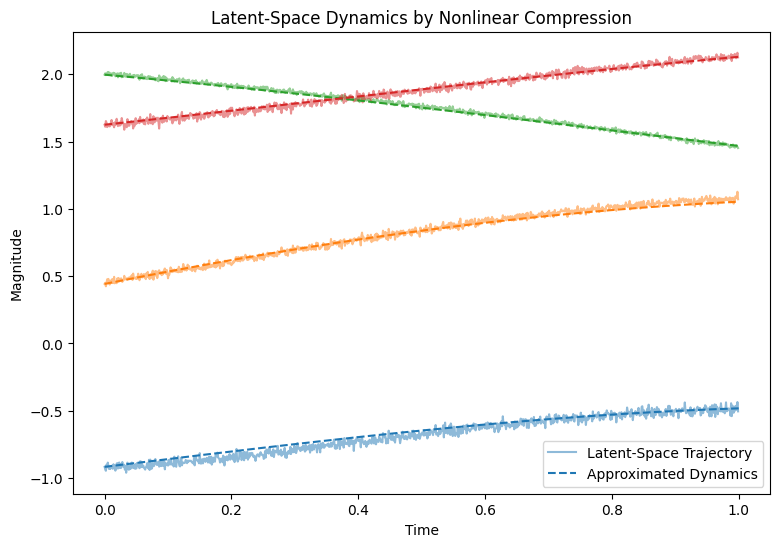

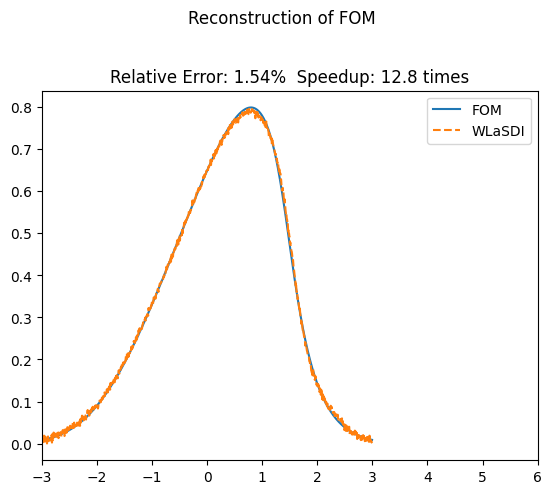

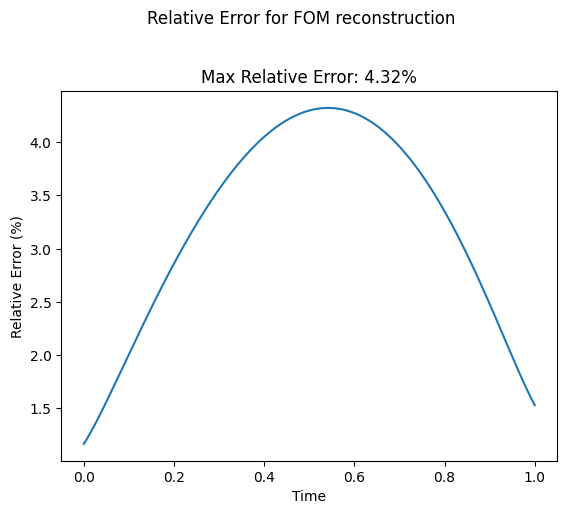

In [44]:
start = time.time()
FOM_recon = WLaSDI_model.generate_ROM(snapshot_full_FOM[0], np.hstack((amp_test,width_test)),t)
WLaSDI_time = time.time()-start

print('Final Position Error: {:.3}%'.format(LA.norm(FOM_recon[-1]-snapshot_full_FOM[-2])/LA.norm(snapshot_full_FOM[-2])*100))
fig = plt.figure()
ax = plt.axes()
fig.suptitle('Reconstruction of FOM', y = 1.05)
ax.set_title('Relative Error: {:.3}%  Speedup: {:.3} times'.format(LA.norm(FOM_recon[-1]-snapshot_full_FOM[-2])/LA.norm(snapshot_full_FOM[-2])*100, FOM_time/LaSDI_time))
ax.plot(x[:-1],snapshot_full_FOM[-1], label = 'FOM')
ax.plot(x[:-1], FOM_recon[-1],'--', label = 'WLaSDI')
ax.legend()
ax.set_xlim(-3,6)


FOM_re = np.empty(nt+1)
for i in range(nt+1):
    FOM_re[i] = LA.norm(FOM_recon[i]-snapshot_full_FOM[i])/LA.norm(snapshot_full_FOM[i])

fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction', y = 1.05)
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(np.amax(FOM_re)*100))
ax.plot(t, FOM_re*100)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')
# torch.cuda.empty_cache()